In [1]:
from Obstacle import *
from Visualization import *
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from Utils.Node import *
from Utils.MathUtils import *
import math
import queue

import csv
import random
import copy

In [2]:
def getRandomNode():
    state = [random.uniform(0, 9), random.uniform(0,9)]
    return Node(state, None, None, None, None)

In [3]:
def getNearestNodeIndex(node_list, random_point):
    distance = []
    for node in node_list:
        node_pts = node.getState()
        d = ((node_pts[0] - random_point[0])**2 + (node_pts[1] - random_point[1])**2)**0.5
        distance.append(d)
    min_idx = distance.index(min(distance))

    return min_idx

In [4]:
def calculate_d_and_theta(start, end):
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    d = math.hypot(dx, dy)
    theta = math.atan2(dy, dx)
    return d, theta

In [5]:
def getNewNode(nearest_node, random_point, sample_rate, obs):
    nearest_point = nearest_node.getState()

    if obs.isInObstacleSpace(nearest_point[0], nearest_point[1]):
        print('Nearest point in OBSTACLE SPACE')
    
    new_node  = Node(nearest_point, nearest_node, None, None, [])
    distance, theta = calculate_d_and_theta(new_node.getState(), random_point)

    if distance < sample_rate:
        sample_rate = distance
    # generate the intermediatary path points
    n_states = math.floor(sample_rate/0.5)
    new_node.pathArray.append(new_node.getState())

    x = new_node.state[0]
    y = new_node.state[1]
    for i in range(n_states):
        x += 0.5*math.cos(theta)
        y += 0.5*math.sin(theta)
        if obs.isInObstacleSpace(x, y):
            #return None
            break
        new_node.pathArray.append([x, y])
        new_node.state = [x,y]

    #if the new node is inside path resolution of random node, consider random node as end of new node
    # distance, theta = calculate_d_and_theta(new_node.getState(), random_point)
    # if distance <= 0.5:
    #     new_node.pathArray.append(random_point)
    #     new_node.state = random_point
    
    #set the new cost
    new_node.cost = nearest_node.getCost() + sample_rate

    return new_node


In [6]:
def visualize(viz, traversed_nodes, goal_node, obs):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set(xlim=(0, 10), ylim = (0,10))
    ax = viz.addObstacles2Map(ax)
    ax.set_aspect("equal")
    c = 0
    print(len(traversed_nodes))
    for node in traversed_nodes:
        xi, yi = node.getState()
        points = node.getPathArray()
        if points is not None:
            for point in points:
                xn, yn = point
                ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 0.3)
                xi, yi = xn, yn
    
    current_node = copy.copy(goal_node)
    nodes = []
    while(current_node.getParent() is not None):
        nodes.append(current_node)
        current_node = current_node.getParent()
    nodes.append(current_node)
    nodes.reverse()

    for node in nodes:
        xi, yi = node.getState()
        ax.scatter(xi, yi)
        points = node.getPathArray()
        if points is not None:
            for point in points:
                xn, yn = point
                if obs.isInObstacleSpace(xn, yn):
                    print('In obstacle space')
                ax.plot([xi, xn], [yi, yn], color="green", linewidth = 2)
                xi, yi = xn, yn
    return nodes


In [17]:
height, width = 10, 10
path_resolution, threshold = 0.5, 0.5
sample_rate = 1
rand_map = [width-1, height-1]
start_point = [0,0]
goal_state = [9,9]
obs = Obstacle(0.0)
viz = Visualization(obs)

node_array = np.array([[[math.inf for k in range(360)] for j in range(int(height/threshold))] for i in range(int(width/threshold))])

goal_reached = False
start_node = Node(start_point, None, None, 0, [])
goal_node = Node(goal_state, None, None, math.inf, [])
final_node = None
node_list = [start_node]

for i in range(5000):
    random_node = getRandomNode()
    if (random_node == None):
        continue
    nearest_idx = getNearestNodeIndex(node_list, random_node.getState())
    nearest_node = node_list[nearest_idx]
    nearest_point = nearest_node.getState()

    new_node = getNewNode(nearest_node, random_node.getState(), sample_rate, obs)
    if (new_node == None):
        continue
    
    if not obs.isInObstacleSpace(new_node.getState()[0], new_node.getState()[1]):
        node_list.append(new_node)
        x_new = int(halfRound(new_node.getState()[0])/threshold)
        y_new = int(halfRound(new_node.getState()[1])/threshold)
        d_goal = ((node_list[-1].getState()[0]- goal_state[0])**2 + (node_list[-1].getState()[1]- goal_state[1])**2)**0.5

        # if (new_node.getCost() < node_array[x_new,y_new,0]):
        #     node_array[x_new,y_new,0] = new_node.getCost() 

        if (d_goal <= 0.5):
            # final_node = getNewNode(node_list[-1], goal_state, sample_rate, obs)
            print('Final node get state = ',new_node.getState())
            if not obs.isInObstacleSpace(new_node.getState()[0], new_node.getState()[1]):
                print('Goal Reached, cost = ', new_node.getCost())
                x_goal = int(halfRound(goal_node.getState()[0])/threshold)
                y_goal = int(halfRound(goal_node.getState()[1])/threshold)
                print(node_array[x_goal, y_goal, 0])
                if (new_node.getCost() <  node_array[x_goal, y_goal, 0]):
                    print('Update final node cost, state = ', x_goal, ', ',y_goal)
                    print('from: ', node_array[x_goal, y_goal, 0], ' to :', new_node.getCost())
                    node_array[x_goal,y_goal,0] = new_node.getCost() 
                    goal_node_final = new_node
                    #node_list.append(goal_node)
                    #break
                print('------------------------')
                

Final node get state =  [8.88315096913121, 8.835258053177423]
Goal Reached, cost =  18.61676180796617
inf
Update final node cost, state =  18 ,  18
from:  inf  to : 18.61676180796617
------------------------
Final node get state =  [8.88315096913121, 8.835258053177423]
Goal Reached, cost =  18.818836117758703
18.61676180796617
------------------------
Final node get state =  [8.88315096913121, 8.835258053177423]
Goal Reached, cost =  18.727754045815026
18.61676180796617
------------------------
Final node get state =  [8.88315096913121, 8.835258053177423]
Goal Reached, cost =  18.994558404432063
18.61676180796617
------------------------
Final node get state =  [8.88315096913121, 8.835258053177423]
Goal Reached, cost =  18.918084825491874
18.61676180796617
------------------------
Final node get state =  [8.88315096913121, 8.835258053177423]
Goal Reached, cost =  18.800917498615664
18.61676180796617
------------------------
Final node get state =  [8.88315096913121, 8.835258053177423]


1002


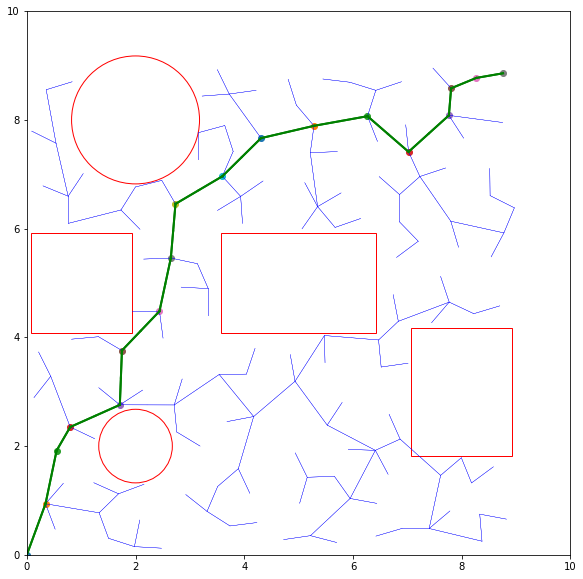

In [15]:
node_list.append(goal_node_final)
nodes = visualize(viz, node_list, goal_node_final, obs)